In [8]:
import torch
from torchtext.vocab import vocab
from torch import nn
import os 
import sys
from gensim.models import Word2Vec
import pandas as pd
from scipy.stats import spearmanr
from box_embeddings.modules.volume.volume import Volume
from box_embeddings.modules.intersection import Intersection
sys.path.append("../")
from utils.model import BoxModel
direc = "/home/fmollica/word2box_pytorch/weights/skipgram_WikiText103/epochs_3_min_count_50_batch_size_4096_embed_dim_10_lr_0.001_window_10_neg_count_1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(f'{direc}/model_final.pt', map_location=device)
vocab = torch.load(f'{direc}/vocab.pt')
word2vec_model = Word2Vec.load(f'{direc}/word2vec.model')

In [3]:
model

BoxModel(
  (embeddings_word): BoxEmbedding(42038, 20)
  (embeddings_context): BoxEmbedding(42038, 20)
  (box_vol): Volume()
  (box_int): Intersection()
  (vocab): Vocab()
)

In [4]:
def most_similar_2(word, N=None):

        if N is None:
            N = len(model.vocab)

        embedding_all_target = model.embeddings_word.all_boxes

        index_word = (model.vocab[word])

        embedding_word = embedding_all_target[index_word]
                
        sim3 = torch.exp(model.box_vol(model.box_int(embedding_all_target, embedding_word))- torch.maximum(model.box_vol(embedding_word),model.box_vol(embedding_all_target)))

        idx = (-sim3).argsort()

        for i, index in enumerate(idx[0:50]):
            print("Similar to : ", str(index.item()),   model.vocab.lookup_token(index))

In [5]:
from scipy import spatial
def most_similar_2_cosine(word, N=None):

        if N is None:
            N = len(model.vocab)

        embedding_all_target = model.embeddings_word.all_boxes

        index_word = (model.vocab[word])
                
        centroid_word = ((embedding_all_target[index_word].z + embedding_all_target[index_word].Z)/2)       

        centroid_others = ((embedding_all_target.z + embedding_all_target.Z)/2)
        
        cosine = torch.nn.CosineSimilarity(dim=1)

        sim3 = cosine(centroid_word, centroid_others)

        idx = (-sim3).argsort()

        for i, index in enumerate(idx[0:50]):
            print("Similar to : ", str(index.item()),   model.vocab.lookup_token(index))

In [6]:
from tqdm import tqdm
import pickle
sentence_length = 0
sentence_count = 0
word_count = 0
total_word_count = 0
word2id = dict()
id2word = dict()
word_frequency = dict()
word_frequency_new = dict()
word_frequency_vocab = dict()
final_vocab = None
min_count = 50

word_frequency = dict()

with open('/home/fmollica/word2box_pytorch/corpus/WikiText103.txt') as f:
    for line in tqdm(f):
        sentence_count += 1
        line = line.strip().split(' ')
        if line==['']:
            line=[]
            sentence_length += 0
        else:
            sentence_length += len(line)

        for w in line:
            total_word_count += 1
            try:
                word_frequency[w] += 1
            except:
                word_frequency[w] = 1

print("Finita la lettura del file")
print("lunghezza del dict", len(word_frequency))


wid = 0

for w, c in word_frequency.items():
    if c < min_count:
        sentence_length -= c
        continue
    word2id[w] = wid
    id2word[wid] = w
    word_frequency_new[wid] = c
    word_frequency_vocab[w] = c
    wid += 1

with open(direc + '/frequency.pickle', 'wb') as handle:
    pickle.dump(word_frequency_new, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(direc + '/frequency.pickle', 'rb') as handle:
    b = pickle.load(handle)

1158870it [00:18, 61686.87it/s]


Finita la lettura del file
lunghezza del dict 202935


In [9]:
import pickle
embedding_all_target = model.embeddings_word.all_boxes
volumes = model.box_vol(embedding_all_target)
volumes_int = torch.exp(volumes)

idx = (-volumes).argsort()

with open(direc + '/frequency.pickle', 'rb') as handle:
    b = pickle.load(handle)

lista_idx = list(range(0,len(volumes_int.tolist())))

frequency = [b[x] for x in lista_idx]
print(len(volumes_int.tolist()))
print(len(frequency))



model.vocab.lookup_token(0)


42038
42038


'valkyria'

In [8]:
%pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached matplotlib-3.5.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached scipy-1.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
  Using cached pandas-1.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached numpy-1.22.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.7-py3-none-any.whl (98 kB)
  Using cached fonttools-4.29.1-py3-none-any.whl (895 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached kiwisolver-1.3.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached Pillow-9.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)
ERROR: pandas 1.4.1 has requirement python-dateutil>=2.8.1, but you'll have python-dateutil 2.7.

In [10]:
import pandas as pd


data = {"frequency": frequency, "volumes": volumes_int.tolist()}

dataframe = pd.DataFrame(data)
print(dataframe.describe())

print(type(dataframe["frequency"].value_counts()))

idx = 2
new_col = dataframe["frequency"].value_counts()  # can be a list, a Series, an array or a scalar
df = pd.DataFrame(new_col)
df.reset_index(level=0, inplace=True)
df.rename(columns={"index":"frequency", "frequency":"number"} ,inplace=True)

grouped_df = dataframe.groupby("frequency")

min_quantile = grouped_df.quantile(0.025)
max_quantile = grouped_df.quantile(0.975)

medians = grouped_df.median()
means = grouped_df.mean()

df = df.assign(max_quantile=min_quantile["volumes"].values)
df = df.assign(min_quantile=max_quantile["volumes"].values)
df = df.assign(median=medians["volumes"].values)
df = df.assign(mean=means["volumes"].values)
df


           frequency       volumes
count   42038.000000  4.203800e+04
mean     1097.847281  2.419210e+03
std      4753.861460  4.642168e+04
min        50.000000  8.323970e-10
25%        82.000000  3.563383e-06
50%       163.000000  5.775541e-05
75%       484.000000  2.464872e-02
max    204049.000000  3.893444e+06
<class 'pandas.core.series.Series'>


,frequency,number,max_quantile,min_quantile,median,mean
0,50,478,3.960356e-08,7.353371e-05,2.054838e-06,1.014611e-05
1,53,457,4.704679e-08,9.763993e-05,2.094213e-06,1.275410e-05
2,51,442,4.513009e-08,8.984710e-05,2.464568e-06,1.219852e-05
3,52,435,4.164457e-08,8.130644e-05,2.354934e-06,1.188386e-05
4,55,432,5.569381e-08,1.039076e-04,2.475535e-06,1.240588e-05
...,...,...,...,...,...,...
5006,5397,1,3.444175e+05,3.444175e+05,3.444175e+05,3.444175e+05
5007,3133,1,2.411586e+06,2.411586e+06,2.411586e+06,2.411586e+06
5008,26230,1,1.509402e+06,1.509402e+06,1.509402e+06,1.509402e+06
5009,12444,1,8.632256e+05,8.632256e+05,8.632256e+05,8.632256e+05


In [12]:
%matplotlib inline
dataframe[dataframe["volumes"]<=dataframe["volumes"].quantile(0.75)].plot.kde()

<AxesSubplot:ylabel='Density'>

In [13]:
for i, value in enumerate(frequency):

    if value >= 100000:
        print(model.vocab.lookup_token(i), "frequency:", value)

game frequency: 137389
time frequency: 165513
first frequency: 204049
also frequency: 184893
year frequency: 154285
would frequency: 126593
one frequency: 193325
two frequency: 171042
new frequency: 153024
state frequency: 118036


In [5]:
df["number"].plot.kde()

# si evince che il corpus presenta un elevato numero di parole che hanno stessa frequenza 

<AxesSubplot:ylabel='Density'>

In [6]:
df["frequency"].plot.kde()

# densità della frequenza delle parole, si evince che devo considerare un range di frequenze per analizzare la correlazione del volume in quanto le parole che occorrono per grandissimi numeri sono poche

<AxesSubplot:ylabel='Density'>

In [7]:
subsetDataFrame = df[df['frequency'] <= 5000]

subsetDataFrame["frequency"].plot.kde()

# la maggiore parte delle parole occorre tra 0 e 500

<AxesSubplot:ylabel='Density'>

      frequency  number  max_quantile   min_quantile         median  \
0            50     478  3.960356e-08       0.000074       0.000002   
1            53     457  4.704679e-08       0.000098       0.000002   
2            51     442  4.513009e-08       0.000090       0.000002   
3            52     435  4.164457e-08       0.000081       0.000002   
4            55     432  5.569381e-08       0.000104       0.000002   
...         ...     ...           ...            ...            ...   
4941       1950       1  3.576999e+03    3576.999268    3576.999268   
4951        913       1  5.868705e+03    5868.704590    5868.704590   
4968       1324       1  6.742976e+05  674297.562500  674297.562500   
4973       1312       1  2.566218e+05  256621.765625  256621.765625   
5010       1682       1  9.155298e+04   91552.976562   91552.976562   

               mean  
0          0.000010  
1          0.000013  
2          0.000012  
3          0.000012  
4          0.000012  
...            

<AxesSubplot:xlabel='frequency'>

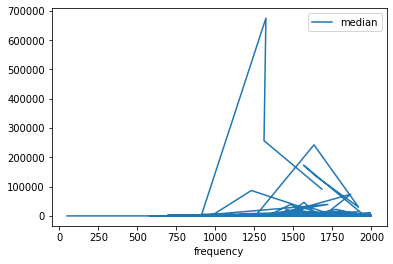

In [25]:
# generate random variables
import matplotlib.pyplot as plt
# bin the values and determine the envelopes
###
# Plot 1

subsetDataFrame = df[df['frequency'] <= 2000]
###
print(subsetDataFrame)
# determine the colors

subsetDataFrame.plot(kind="line", x="frequency", y="median")

In [26]:
df.describe()

,frequency,number,max_quantile,min_quantile,median,mean
count,5011.000000,5011.000000,5.011000e+03,5.011000e+03,5.011000e+03,5.011000e+03
mean,6804.042706,8.389144,1.972811e+04,2.020421e+04,1.994203e+04,1.995799e+04
std,12234.734915,32.343914,1.330016e+05,1.331096e+05,1.330178e+05,1.330159e+05
min,50.000000,1.000000,2.935185e-08,1.358329e-06,1.358329e-06,1.358329e-06
25%,1311.500000,1.000000,5.674462e-01,1.379824e+01,3.325002e+00,7.294308e+00
50%,3064.000000,1.000000,8.185394e+01,1.815070e+02,1.244614e+02,1.361562e+02
75%,7174.500000,3.000000,1.477353e+03,2.079589e+03,1.821294e+03,1.841469e+03
max,204049.000000,478.000000,3.893444e+06,3.893444e+06,3.893444e+06,3.893444e+06


<AxesSubplot:ylabel='Density'>

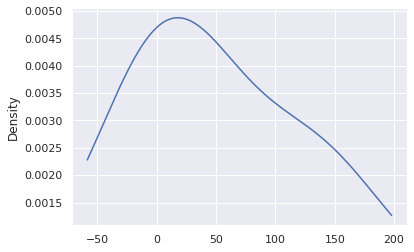

In [12]:
# analisi qualitativa dello spazio di box embedding generato.
# prima analisi per capire se vi è una correlazione tra il volume di un box e la rispettiva frequenza all'interno del corpus.
# stiamo analizzando come volumi di parole che hanno la stessa frequenza siano simili tra loro, perchè analizzando la funzione di densità dei volumi data una singola 
# frequenza, il grafico assume una curva a campana.
# per questo motivo può essere utile procedere considerando come volume di riferimento per ogni gruppo di frequenza la mediana proprio perchè ho visto che il grafico ha questo andamento.


grouped_df = dataframe.groupby("frequency")
#grouped_df.get_group(50)["volumes"]
grouped_df.get_group(2000)["volumes"].plot.kde()


In [79]:
def save_correlations_results(direc):

    volume = model.box_vol
    intersection = model.box_int

    boxes = model.embeddings_word.all_boxes

    rows_data_int = []
    rows_data_w_int = []
    rows_data_centroids = []

    for filename in os.listdir("/home/fmollica/word2box_pytorch/word_similarity_dataset"):
        dataframe = pd.read_csv("/home/fmollica/word2box_pytorch/word_similarity_dataset/" + filename)
        dataframe.rename( columns={'Unnamed: 0':'index'}, inplace=True )

        list_similarity_word2box_intersection = []
        list_similarity_word2box_weighted_intersection = []
        list_similarity_word2box_centroids = []
        list_similarity_word2vec = []
        list_similarity_sota = []

        if filename!="men.csv":
            for i, row in dataframe.iterrows():
                try:
                    word1_word2vec = word2vec_model.wv.key_to_index[row["word1"]]
                    word2_word2vec = word2vec_model.wv.key_to_index[row["word2"]]
                    word1_word2box = vocab.lookup_indices([row["word1"]])[0]
                    word2_word2box = vocab.lookup_indices([row["word2"]])[0]
                except: 
                    continue
                
                list_similarity_word2vec.append(word2vec_model.wv.similarity(row["word1"], row["word2"]))
                list_similarity_sota.append(row["similarity"])
                #####SIMPLE INTERSECTION BETWEEN BOXES#####
                list_similarity_word2box_intersection.append(torch.exp(volume(intersection(boxes[word1_word2box], boxes[word2_word2box]))).item())
                #####WEIGHTED INTERSECTION BETWEEN BOXES####
                list_similarity_word2box_weighted_intersection.append(torch.exp(volume(intersection(boxes[word1_word2box], boxes[word2_word2box]))-torch.maximum(volume(boxes[word1_word2box]), volume(boxes[word2_word2box]))).item())
                #####COSINE SIMILARITY BETWEEN CENTROIDS#####
                centroid_word1 = ((boxes[word1_word2box].z + boxes[word1_word2box].Z)/2).tolist()
                centroid_word2 = ((boxes[word2_word2box].z + boxes[word2_word2box].Z)/2).tolist()
                list_similarity_word2box_centroids.append(1 - spatial.distance.cosine(centroid_word1, centroid_word2))
                

            rho_vec, p_vec = spearmanr(list_similarity_word2vec, list_similarity_sota)
            rho_box_int, p_box_int = spearmanr(list_similarity_word2box_intersection, list_similarity_sota)
            rho_box_w_int, p_box_w_int = spearmanr(list_similarity_word2box_weighted_intersection, list_similarity_sota)
            rho_box_centroids, p_box_centroids = spearmanr(list_similarity_word2box_centroids, list_similarity_sota)



        else:
            for i, row in dataframe.iterrows():
                try:
                    word1_word2vec = word2vec_model.wv.key_to_index[row["word1"][:-2]]
                    word2_word2vec = word2vec_model.wv.key_to_index[row["word2"][:-2]]
                    word1_word2box = vocab.lookup_indices([row["word1"][:-2]])[0]
                    word2_word2box = vocab.lookup_indices([row["word2"][:-2]])[0]
                except: 
                    continue
                
                list_similarity_word2vec.append(word2vec_model.wv.similarity(row["word1"][:-2], row["word2"][:-2]))
                list_similarity_sota.append(row["similarity"])
                #####SIMPLE INTERSECTION BETWEEN BOXES#####
                list_similarity_word2box_intersection.append(torch.exp(volume(intersection(boxes[word1_word2box], boxes[word2_word2box]))).item())
                #####WEIGHTED INTERSECTION BETWEEN BOXES####
                list_similarity_word2box_weighted_intersection.append(torch.exp(volume(intersection(boxes[word1_word2box], boxes[word2_word2box]))-torch.maximum(volume(boxes[word1_word2box]), volume(boxes[word2_word2box]))).item())
                #####COSINE SIMILARITY BETWEEN CENTROIDS#####
                centroid_word1 = ((boxes[word1_word2box].z + boxes[word1_word2box].Z)/2).tolist()
                centroid_word2 = ((boxes[word2_word2box].z + boxes[word2_word2box].Z)/2).tolist()
                list_similarity_word2box_centroids.append(1 - spatial.distance.cosine(centroid_word1, centroid_word2))

            rho_vec, p_vec = spearmanr(list_similarity_word2vec, list_similarity_sota)
            rho_box_int, p_box_int = spearmanr(list_similarity_word2box_intersection, list_similarity_sota)
            rho_box_w_int, p_box_w_int = spearmanr(list_similarity_word2box_weighted_intersection, list_similarity_sota)
            rho_box_centroids, p_box_centroids = spearmanr(list_similarity_word2box_centroids, list_similarity_sota)

        rows_data_int.append([filename[:-4], rho_vec, p_vec, rho_box_int, p_box_int])
        rows_data_w_int.append([filename[:-4], rho_vec, p_vec, rho_box_w_int, p_box_w_int])
        rows_data_centroids.append([filename[:-4], rho_vec, p_vec, rho_box_centroids, p_box_centroids])

    columns_ = ["dataset", "rho_vec", "p_vec", "rho_box", "p_box"]

    dataf_int = pd.DataFrame(rows_data_int, columns = columns_)
    dataf_w_int = pd.DataFrame(rows_data_w_int, columns = columns_)
    dataf_centroids = pd.DataFrame(rows_data_centroids, columns = columns_)

    dataf_int.to_pickle(direc + "/simple_intersection_correlations.pkl")
    dataf_w_int.to_pickle(direc + "/weighted_intersection_correlations.pkl")
    dataf_centroids.to_pickle(direc + "/centroids_correlations.pkl")



In [80]:
save_correlations_results(os.getcwd())

In [81]:
import pickle
with open(os.getcwd() + '/weighted_intersection_correlations.pkl', 'rb') as f:
    data = pickle.load(f)


data

,dataset,rho_vec,p_vec,rho_box,p_box
0,verb-143,0.292908,1.723777e-03,0.023451,0.806120
1,mturk-771,0.535639,7.663649e-57,0.054346,0.137296
2,rg-65,0.621062,3.395660e-08,0.053546,0.671834
3,men,0.586920,1.421016e-271,0.065191,0.000406
4,wordsim353-rel,0.478083,1.354640e-14,-0.057234,0.386558
5,yp-130,0.267674,3.673529e-03,0.023838,0.799500
6,simverb-3500,0.123404,3.176121e-12,0.023028,0.195038
7,mc-30,0.660436,7.137369e-05,0.182798,0.333613
8,simlex999,0.161563,3.437942e-07,0.030654,0.336519
9,mturk-287,0.597301,1.561581e-23,0.023916,0.718859
